# Modelo de predicción de diabetes

Se utiliza el dataset generado en el notebook anterior (`data/dataser1.csv`) para encontrar un modelo que prediga si un paciente con determinados síntomas tiene diabete o no. 

A continuación se utilizarán 3 tipos de modelos de clasificación: 
- Logistisc Regression
- Random Forest y 
- Decision Tree

Para encontrar lo mejores hiperparámetros para cada uno de los diferentes modelos se realiza una búsqueda utilizando `GridSearchCV` y validación cruzada `Kfold` de la librería de `sklearn`.

Se importan los paquete a usar:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import (cross_validate, KFold)

Se define una función para imprimir en pantalla las métricas y realizar la gráfica de la matriz de confusión:

In [2]:
def calculate_metrics(y_test, y_predicted, model=None):
    print(f"Metricas del {model}", "\n")
    print('Accuracy Score:', metrics.accuracy_score(y_test, y_predicted))
    print('Precision Score:', metrics.precision_score(y_test, y_predicted))
    print('Recall Score:', metrics.recall_score(y_test, y_predicted), "\n") 
    print(metrics.classification_report(y_test, y_predicted))
    
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_predicted,
        cmap='Blues', 
        colorbar=False,
        normalize="true",
    )
    plt.title("Matriz de confusion")
    plt.show()

Se carga el dataset `datos/dataset_1.csv` usando la librería de `pandas`:

In [2]:
dataset = pd.read_csv("../data/dataset_1.csv")

dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72.0,35.000000,119.551524,33.6,0.627,50,1
1,1,85,66.0,29.000000,288.225858,26.6,0.351,31,0
2,8,183,64.0,20.939621,135.133308,23.3,0.672,32,1
3,1,89,66.0,23.000000,94.000000,28.1,0.167,21,0
4,0,137,40.0,35.000000,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
746,10,101,76.0,48.000000,180.000000,32.9,0.171,63,0
747,2,122,70.0,27.000000,295.121677,36.8,0.340,27,0
748,5,121,72.0,23.000000,112.000000,26.2,0.245,30,0
749,1,126,60.0,43.152910,91.280287,30.1,0.349,47,1


In [4]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,751.0,3.853529,3.376761,0.000,1.000000,3.000,6.000000,17.00
Glucose,751.0,121.841545,30.498528,44.000,99.500000,117.000,141.000000,199.00
BloodPressure,751.0,73.015769,12.706673,24.000,64.000000,72.000,80.000000,122.00
SkinThickness,751.0,31.076000,10.285288,7.000,23.776798,31.000,39.000000,63.00
Insulin,751.0,174.739845,99.316711,14.000,102.203090,160.000,229.354901,846.00
BMI,751.0,32.451664,6.933059,18.200,27.500000,32.300,36.600000,67.10
DiabetesPedigreeFunction,751.0,0.472915,0.330307,0.078,0.244000,0.376,0.628000,2.42
Age,751.0,33.274301,11.670218,21.000,24.000000,29.000,41.000000,81.00
Outcome,751.0,0.350200,0.477350,0.000,0.000000,0.000,1.000000,1.00


Se plotea nuevamente la distribución de las clases en la columna Outcome para tener en cuenta la asimetría en el número de datos de individuos con o sin diabetes:

<AxesSubplot: xlabel='Outcome', ylabel='count'>

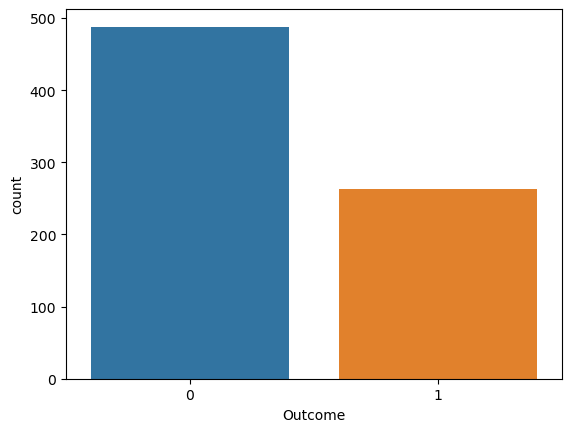

In [5]:
sns.countplot(data=dataset , x='Outcome')

## Separo el dataset 

Se separa el dataset en un grupo de entrenamiento y otro de testeo. 
El primero se servirá para entrenar el modelo que se realice y el segundo para evaluar su performance.

Antes de realizar esta separación, el dataset debe estandarizarse ya que algunas de las variables son mas grande que otras. Para ello voy a usar `StandardScaler`.
Para este procedimiento se utilizarán diferentes herramientas de la librería de `sklearn`.

Se crea el dataset `x_data` y `y_data`:

In [6]:
x_data = dataset.drop(columns=["Outcome"])

x_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72.0,35.000000,119.551524,33.6,0.627,50
1,1,85,66.0,29.000000,288.225858,26.6,0.351,31
2,8,183,64.0,20.939621,135.133308,23.3,0.672,32
3,1,89,66.0,23.000000,94.000000,28.1,0.167,21
4,0,137,40.0,35.000000,168.000000,43.1,2.288,33


In [7]:
y_data = dataset.drop(columns=dataset.columns[:-1])

y_data.head()

,Outcome
0,1
1,0
2,1
3,0
4,1


### Estandarización

In [8]:
# Defino el escalador
scaler = StandardScaler()

# Escalo el conjunto de datos x_data
x_scaler = scaler.fit_transform(x_data)

x_scaler

array([[ 0.6360834 ,  0.85826728, -0.0799931 , ...,  0.16574227,
         0.46680176,  1.43415021],
       [-0.84561212, -1.20878286, -0.55250061, ..., -0.84458601,
        -0.36934129, -0.19501063],
       [ 1.22876161,  2.00662847, -0.71000312, ..., -1.32088363,
         0.60312943, -0.10926533],
       ...,
       [ 0.3397443 , -0.02761135, -0.0799931 , ..., -0.90231906,
        -0.69046869, -0.28075594],
       [-0.84561212,  0.13644025, -1.02500813, ..., -0.33942187,
        -0.3754003 ,  1.17691429],
       [-0.84561212, -0.9463003 , -0.23749561, ..., -0.29612209,
        -0.47840342, -0.88097309]])

### Genero el grupo de entrenamiento y de testeo

El 20% de los datos  se utilizan para generar el grupo de testeo:

In [9]:
# Separo los dataset x_scaler y y_data en train y test
x_train, x_test, y_train, y_test = train_test_split(
    x_scaler,
    y_data, 
    test_size=0.20,
    random_state = 100
)

In [10]:
# Imprimo el tamaño de estos 2 conjuntos de datos 
print("Train shape: ", x_train.shape, "Test shape: ", x_test.shape)

Train shape:  (600, 8) Test shape:  (151, 8)


In [11]:
# Transformo y_train en un array 1D
y_train = [i[0] for i in y_train.values]

## Cálculo del modelo

### Logistic Regression 

In [12]:
# Defino el modelo
logistic_regression = LogisticRegression()

# Defino los parametros para el modelo en donde se hace la busqueda
param_grid = {
    "penalty": ["l2"],
    "C": [100, 600, 500, 100, 10, 1.0, ],
    "solver": ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
    "random_state": [5, 10, 30, 50, 70 ,80, 90],
    "class_weight": ["balanced", None]
}

# Defino la validacion cruzada
cv = KFold(n_splits=10)

# Realizo la búsqueda de los hiperparametros
cv_grid_lrm = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=cv)

# Entreno el modelo con el grupo de entrenamiento
cv_grid_lrm.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid={'C': [100, 600, 500, 100, 10, 1.0],
                         'class_weight': ['balanced', None], 'penalty': ['l2'],
                         'random_state': [5, 10, 30, 50, 70, 80, 90],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

Se muestan los mejore hiperparametros para este modelo:

In [13]:
cv_grid_lrm.best_params_

{'C': 1.0,
 'class_weight': None,
 'penalty': 'l2',
 'random_state': 5,
 'solver': 'lbfgs'}

Se define el modelo con los mejores parámetros y calculo sus métricas

Metricas del Logistic regression model 

Accuracy Score: 0.7814569536423841
Precision Score: 0.6666666666666666
Recall Score: 0.7777777777777778 

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        97
           1       0.67      0.78      0.72        54

    accuracy                           0.78       151
   macro avg       0.77      0.78      0.77       151
weighted avg       0.79      0.78      0.78       151



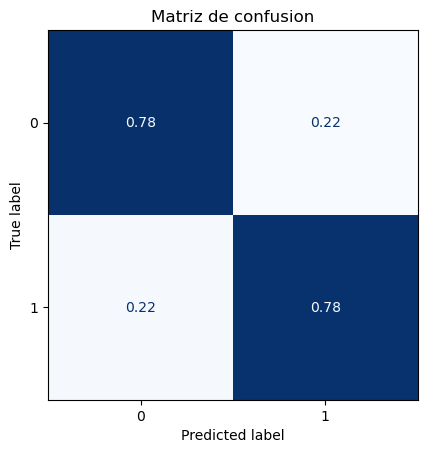

In [14]:
# Defino el modelo con los mejores parametros
logistic_regression = LogisticRegression(
    C=1, 
    penalty="l2", 
    random_state=5, 
    solver='lbfgs', 
    class_weight="balanced",
)

# Entreno el modelo
logistic_regression.fit(x_train, y_train)

# Predigo en el grupo de testeo
y_predicted_lrm = logistic_regression.predict(x_test)

# Calculo las metricas
calculate_metrics(y_test, y_predicted_lrm, "Logistic regression model")

### Ramdon Forest

In [20]:
# Defino el modelo
random_forest = RandomForestClassifier(random_state=11)

# Defino los parametros para el modelo en donde se hace la busqueda
param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators" : [50, 64, 100, 128, 200, 500],
    "max_features" : [2, 3, 4, 5, 6, 7],
    "class_weight": ["balanced", None]
}

# Defino la validacion cruzada
cv = KFold(n_splits=10)

# Realizo la busqueda de los hiperparametros
cv_grid_rf = GridSearchCV(estimator=random_forest, param_grid=param_grid, cv=cv)

# Entreno el modelo con el grupo de entrenamiento
cv_grid_rf.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(random_state=11),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': [2, 3, 4, 5, 6, 7],
                         'n_estimators': [50, 64, 100, 128, 200, 500]})

Se miestran los mejore hiperparametros:

In [21]:
cv_grid_rf.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_features': 3,
 'n_estimators': 128}

Metricas del Random forest model 

Accuracy Score: 0.8410596026490066
Precision Score: 0.8
Recall Score: 0.7407407407407407 

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        97
           1       0.80      0.74      0.77        54

    accuracy                           0.84       151
   macro avg       0.83      0.82      0.82       151
weighted avg       0.84      0.84      0.84       151



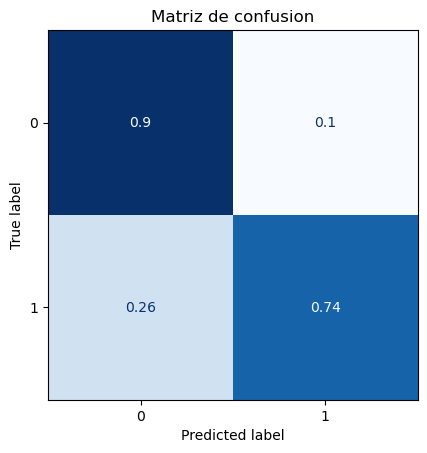

In [15]:
# Defino el modelo con los mejores parametros
random_forest = RandomForestClassifier(
    n_estimators=128,
    criterion= "gini",
    max_features=3,
    class_weight="balanced",
    random_state=11
)

# Entreno el modelo
random_forest.fit(x_train, y_train)

# Predigo en el grupo de testeo
y_predicted_forest = random_forest.predict(x_test)

# Calculo las metricas
calculate_metrics(y_test, y_predicted_forest, "Random forest model")

### Decision Tree

In [16]:
# Defino el modelo
decision_tree = DecisionTreeClassifier()

# Defino los parametros para el modelo en donde se hara la busqueda
param_grid = {
    "min_samples_split": [1, 2, 3, 4, 5, 6, 7],
    "max_depth": [1, 2, 3, 4, 5, 6, 7, 9, 11],
    "criterion": ["entropy", "gini", "log_loss"],
    "class_weight": ["balanced", None],
    "random_state": [11],
}

# Defino la validacion cruzada
cv = KFold(n_splits=10)

# Realido la busqueda de los hiperparametros
cv_grid_tree = GridSearchCV(estimator=decision_tree, param_grid=param_grid, cv=cv)

# Entreno el modelo con el grupo de entrenamiento
cv_grid_tree.fit(x_train, y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['entropy', 'gini', 'log_loss'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 9, 11],
                         'min_samples_split': [1, 2, 3, 4, 5, 6, 7],
                         'random_state': [11]})

Se muestran los mejore hiperparametros:

In [17]:
cv_grid_tree.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 2,
 'min_samples_split': 1,
 'random_state': 11}

Metricas del Decision tree model 

Accuracy Score: 0.8013245033112583
Precision Score: 0.7608695652173914
Recall Score: 0.6481481481481481 

              precision    recall  f1-score   support

           0       0.82      0.89      0.85        97
           1       0.76      0.65      0.70        54

    accuracy                           0.80       151
   macro avg       0.79      0.77      0.78       151
weighted avg       0.80      0.80      0.80       151



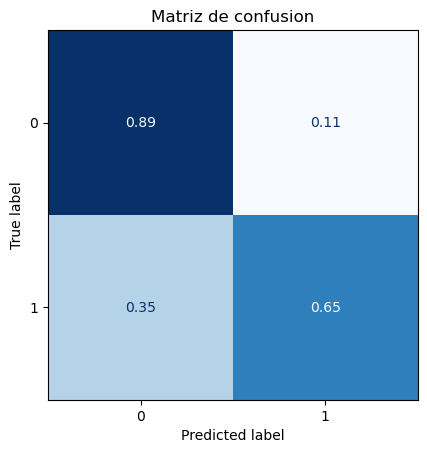

In [18]:
# Defino el modelo con los mejores parametros
decision_tree = DecisionTreeClassifier(
    class_weight="balanced",
    criterion="gini",
    max_depth=2,
    min_samples_split=1,
    random_state=11
)

# Entreno el modelo
decision_tree.fit(x_train, y_train)

# Predigo en el grupo de test
y_predicted_tree = decision_tree.predict(x_test)

# Calculo las metricas
calculate_metrics(y_test, y_predicted_tree, "Decision tree model")

Se crea una carpeta para guadar la figura:

In [ ]:
fig_path = "notebooks/fig"

# Chequeo se existe, sino existe lo creo:
if not os.path.isdir(fig_path):
    os.mkdir(fig_path)

Se guarda la figura con las matrices de confusión:

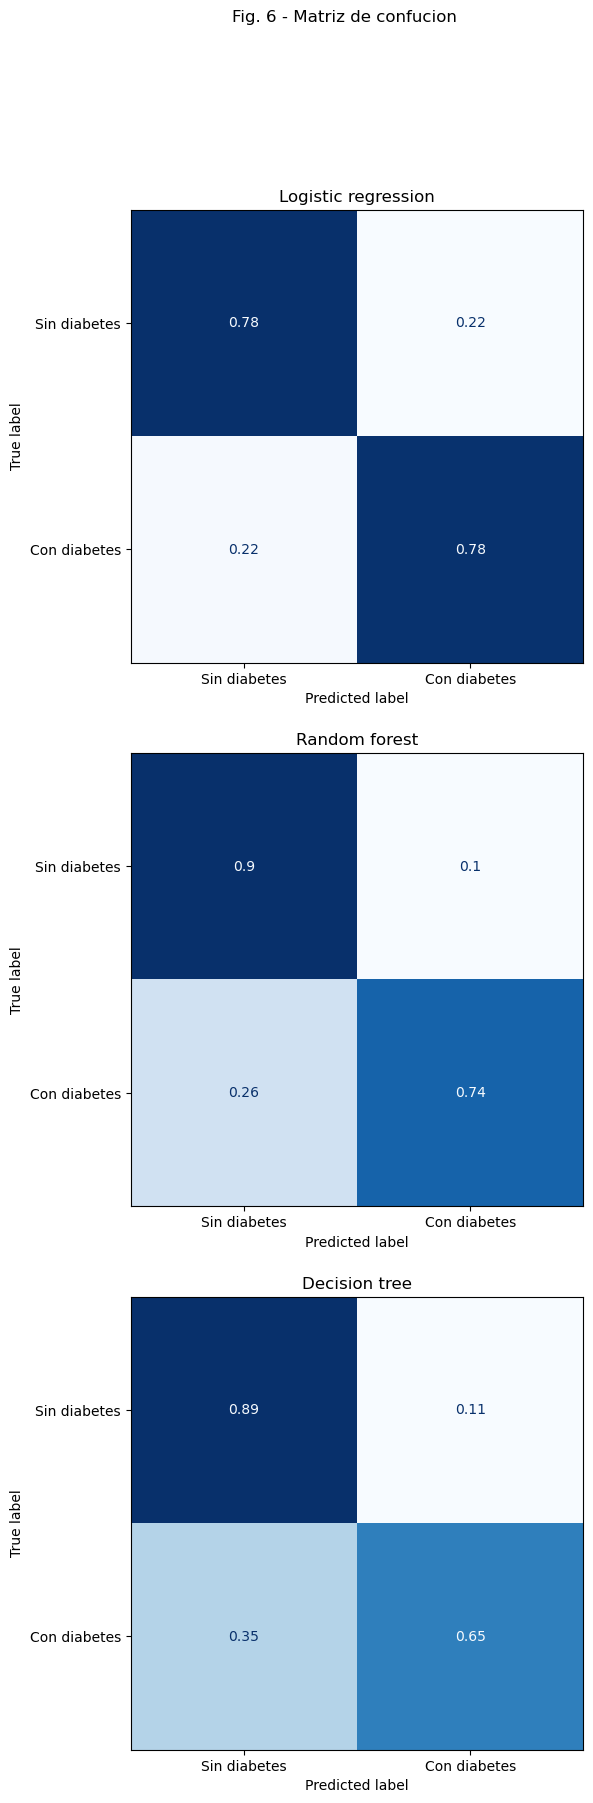

In [58]:
fig , axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))

for y, title, ax in zip(
    [y_predicted_lrm, y_predicted_forest, y_predicted_tree],
    ["Logistic regression", "Random forest", "Decision tree"],
    axs
):
    metrics.ConfusionMatrixDisplay.from_predictions(
        y_test,
        y,
        cmap='Blues', 
        colorbar=False,
        normalize="true",
        ax=ax
    )
    ax.set_xticklabels(["Sin diabetes", "Con diabetes"])
    ax.set_yticklabels(["Sin diabetes", "Con diabetes"])
    ax.set_title(title)

fig.suptitle("Fig. 6 - Matriz de confusion")

#plt.savefig(f"{fig_path}/fig6.png")
plt.show()